# Setup

In [3]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Download the MovieLens dataset and prepare the data


In [4]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [5]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [8]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [9]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

# Construct the Movies graph

### Step 1: create the weighted edges between movies.


In [10]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 883.77it/s]


### Step 2: create the graph with the nodes and the edges

In [11]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 460436.46it/s]


In [12]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [13]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


### Step 3: Create vocabulary and a mapping from tokens to integer indices


In [14]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

# Implement the biased random walk



In [15]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

# Generate training data using the biased random walk


In [16]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:07<00:00, 189.81it/s]

Number of walks generated: 7025


# Generate positive and negative examples


In [17]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating positive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating positive and negative examples: 100%|██████████| 7025/7025 [00:13<00:00, 504.14it/s]


In [18]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (885182,)
Contexts shape: (885182,)
Labels shape: (885182,)
Weights shape: (885182,)


Convert the data into `tf.data.Dataset` objects

In [19]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

# Train the skip-gram model


In [20]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [21]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [22]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

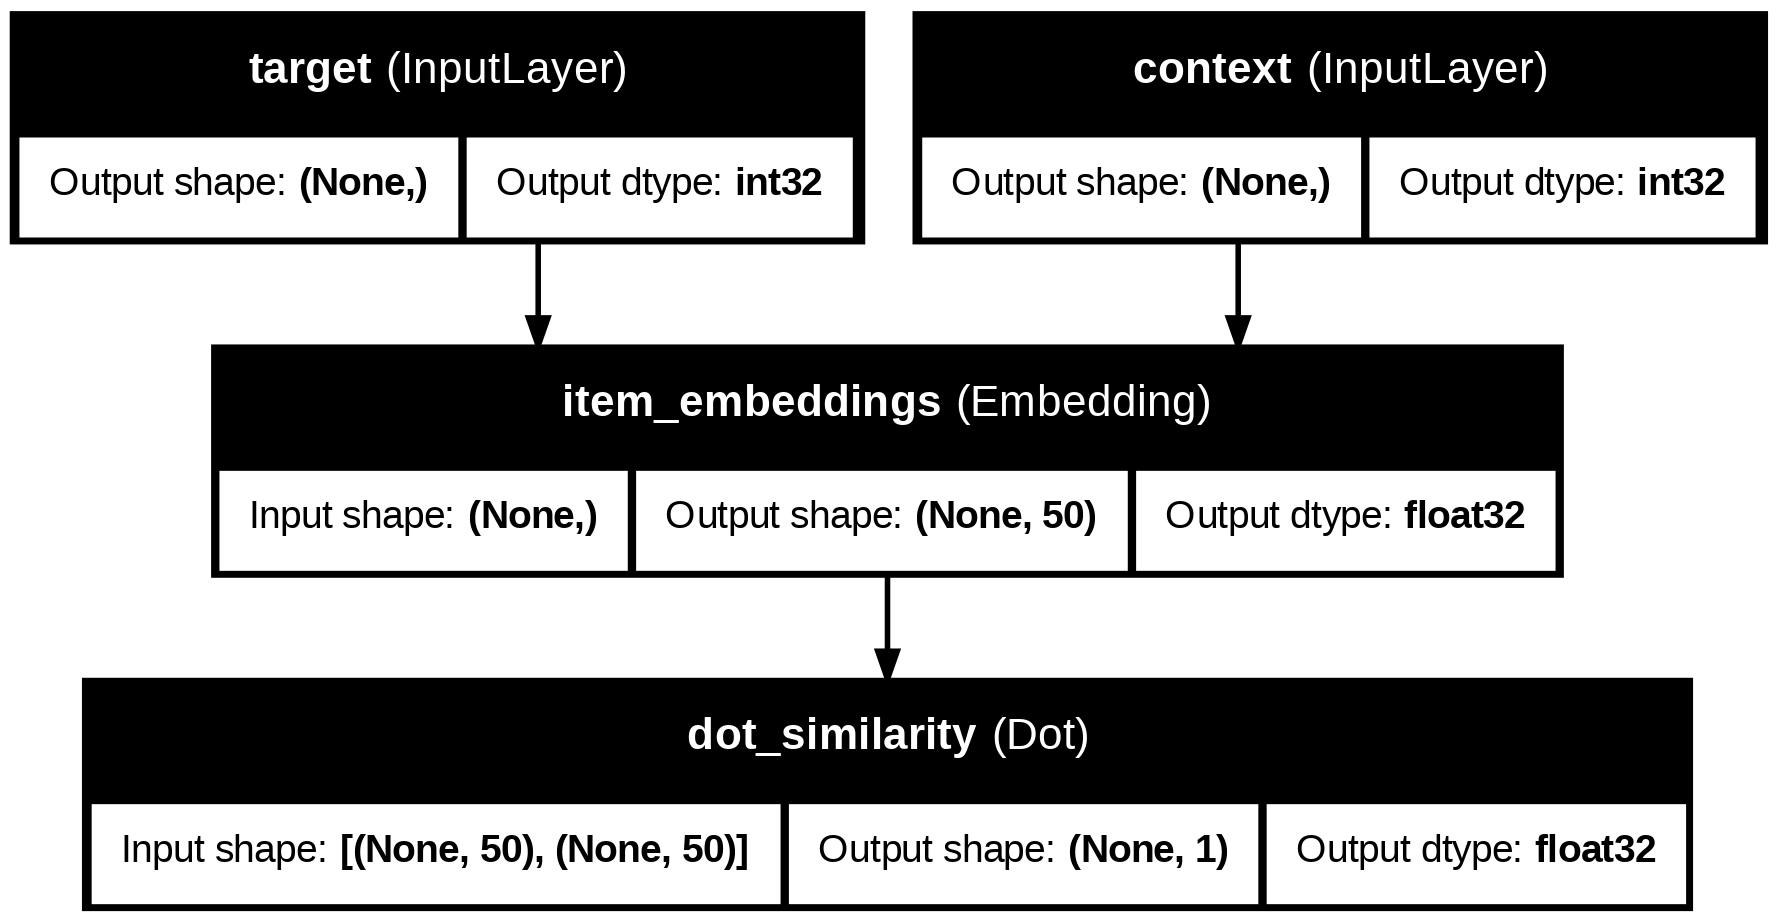

In [23]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [24]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 3.4787
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 3.3245
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 3.3070
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 3.2925
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 3.2806
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 3.2701
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 3.2594
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 3.2519
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 3.2458
Epoch 10/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 3.2400


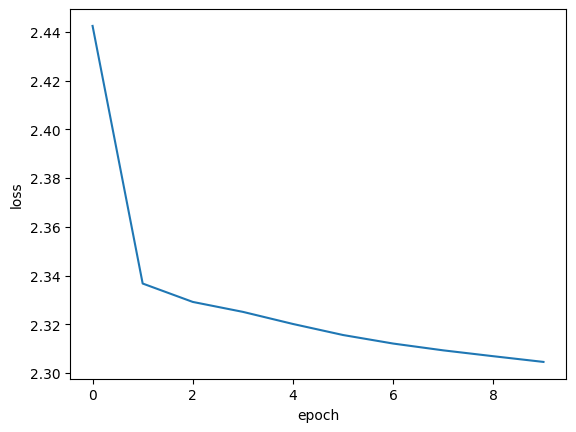

In [25]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Analyze the learnt embeddings

In [26]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


In [27]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [28]:
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [29]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [30]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Matrix, The (1999)
- Fight Club (1999)
- Shawshank Redemption, The (1994)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Inception (2010)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Shawshank Redemption, The (1994)
- Forrest Gump (1994)
- Fight Club (1999)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Apollo 13 (1995)
- Independence Day (a.k.a. ID4) (1996)
- Beauty and the Beast (1991)
- Fugitive, The (1993)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Fugitive, The (1993)
- Forrest Gump (1994)
- Shawshank Redemption, The (1994)
- Braveheart (1995)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Godfather: Part II, The (1974)
- Apocalypse Now (1979)
- Rear Window (1954)
- Fargo (1996)



# Visualize the embeddings using the Embedding Projector


In [31]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()